# Appendix A: Misspecifications in Kernels

In section 3 of the paper, we claim that the variance estimate with covariance is sensitive to a correct specification of a kernel for GPs. 

We will provide empirical evidence for this claim. We assume that our objective function is represented by a Gaussian process with a kernel. Then, we approximate this objective function by 

* a Gaussian process with the same kernel as the objective function (correctly specified)
* a Gaussian process with another kernel (misspecified)

In both cases, we measure the two variance estimates: 

$$
    \hat s_S^2(\lambda_S) = \frac{1}{n^2} {1}^\top {\hat K}\left(\lambda_S\right) ~ {1} \qquad \text{(With Covariances)}
$$

$$
    \hat s_S^2(\lambda_S) = \frac{1}{n} \sum\nolimits_{i = 1}^n {\hat K}\left(\lambda_S\right)_{i,i} \qquad \text{(Covariances omitted)}
$$


## Packages and Scripts

In [8]:
library(ParamHelpers)
library(mlrMBO)
library(smoof)
library(BBmisc)
library(iml)
library(ggplot2)
library(data.table)
library(ggpubr)

theme_set(theme_pubr())

library(data.table)

source("../R/marginal_effect.R")
source("simulate_kernel_misspecification.R")

## Definition of the Experiment

The following function simulates a Gaussian process approximation to the Styblinski-Tang function with a *true* kernel. This GP gives us the *true* objective. 

Then, we approximate this objective by another GP that is correctly specified (*true* kernel), and once with a *wrong* kernel. 

We compute the PDPs, and compute the log-likelihood of the *true* objective under the two different approximations.

We repeat the experiment 50 times for different dimensions 3, 5, 8. 

In [32]:
out = lapply(c(3, 5, 8), function(dim) {
    res = lapply(seq_len(50), function(i) {
        res = simulate_kernel_misspecification(dimension = dim, true_kernel = "matern3_2", wrong_kernel = "gauss", n = 30)
        res$iter = i
    
        res
    })
    
    do.call(rbind, res)
})


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  19.41299 18.73916 18.67873 
  - best initial criterion value(s) :  -158.9282 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       158.93  |proj g|=       0.6613
At iterate     1  f =       158.81  |proj g|=        0.5846
At iterate     2  f =       158.65  |proj g|=       0.95508
At iterate     3  f =       158.57  |proj g|=       0.46325
At iterate     4  f =       158.54  |proj g|=       0.55545
At iterate     5  f =       158.51  |proj g|=       0.17365
At iterate     6  f =        158.5  |proj g|=      0.025138
At iterate     7  f =        158.5  |proj g|=     0.0057824
At iterate     8  f =        158.5  |proj g|=     0.0057876
At it

In [33]:
df = do.call(rbind, out)

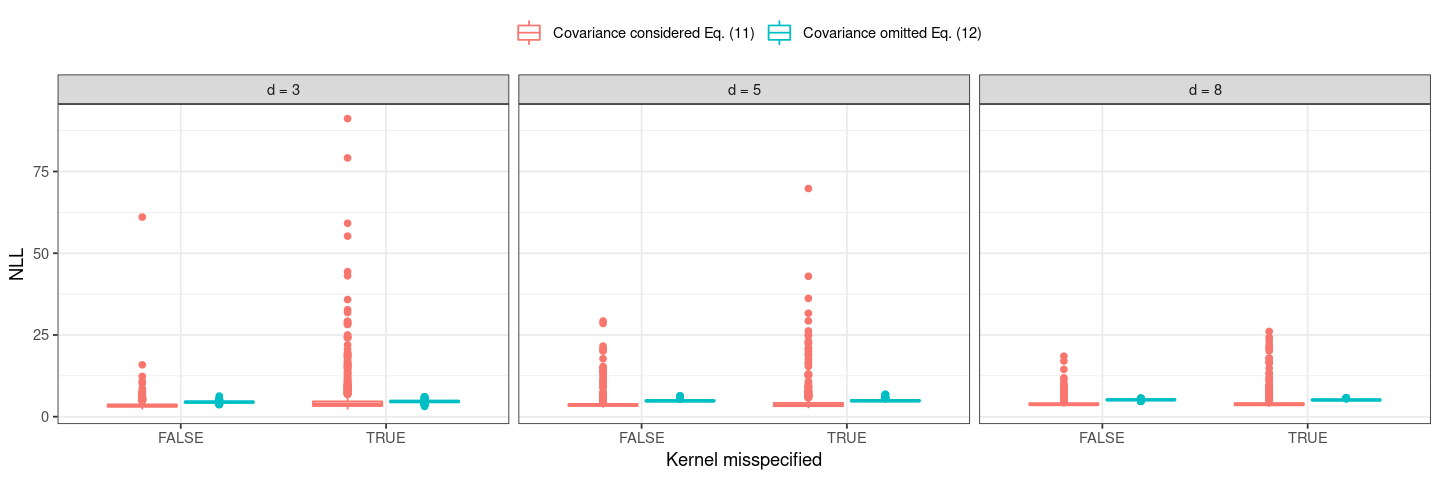

In [52]:
options(repr.plot.width=12, repr.plot.height=4)

df$dim = paste0("d = ", df$dimension)
df$estimate = ifelse(df$type == "pdp_var", "Covariance omitted Eq. (12)", "Covariance considered Eq. (11)")

p = ggplot(data = df, aes(x = misspec, y = neg_loglik, colour = estimate)) + geom_boxplot() + facet_grid(. ~ dim)
p = p + xlab("Kernel misspecified") + ylab("NLL") + theme(legend.direction = "horizontal", legend.position = "top")
p = p + theme(legend.title = element_blank())
p

In [65]:
ggsave("kernel_misspecification.png", p, width = 7.5, height = 3.2)

In [57]:
# Create a Table 
out_t = setDT(df)[, .(mean(neg_loglik), sd(neg_loglik)), by = c("misspec", "type", "dimension")]

In [58]:
out_t$variant = paste0(out_t$type, "_", out_t$misspec)
out_t$value = paste0(round(out_t$V1, 2), " (", round(out_t$V2, 2), ")")

In [61]:
out_t = reshape2::dcast(out_t, formula = dimension ~ variant, value.var = "value")

In [69]:
out_t = out_t[, c(1, 3, 2, 4, 5)]

In [70]:
library(xtable)
print(xtable(out_t, type = "latex"), file = "out.tex", include.rownames = FALSE)